## ELETTRA-20: ID model fit (symmetric: ORM)

In [1]:
# As it can be seen from the optimized knob values, normal local knobs are symmetric, while local skew knobs are antisymmetric
# In this example these constrains are emposed

In [2]:
# Import

import torch
from torch import Tensor

from pathlib import Path

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
matplotlib.rcParams['text.usetex'] = True

from model.library.element import Element
from model.library.line import Line
from model.library.corrector import Corrector
from model.library.quadrupole import Quadrupole
from model.library.matrix import Matrix

from model.command.external import load_lattice
from model.command.build import build
from model.command.tune import tune
from model.command.orbit import dispersion
from model.command.orbit import ORM
from model.command.twiss import twiss
from model.command.advance import advance
from model.command.coupling import coupling

from model.command.wrapper import Wrapper
from model.command.wrapper import forward
from model.command.wrapper import inverse
from model.command.wrapper import normalize

In [3]:
# Set data type and device

Element.dtype = dtype = torch.float64
Element.device = device = torch.device('cpu')

In [4]:
# Load lattice (ELEGANT table)
# Note, lattice is allowed to have repeated elements

path = Path('elettra.lte')
data = load_lattice(path)

In [5]:
# Build and setup lattice

ring:Line = build('RING', 'ELEGANT', data)

# Flatten sublines

ring.flatten()

# Remove all marker elements but the ones starting with MLL (long straight section centers)

ring.remove_group(pattern=r'^(?!MLL_).*', kinds=['Marker'])

# Replace all sextupoles with quadrupoles


def factory(element:Element) -> None:
    table = element.serialize
    table.pop('ms', None)
    return Quadrupole(**table)

ring.replace_group(pattern=r'', factory=factory, kinds=['Sextupole'])

# Set linear dipoles

def apply(element:Element) -> None:
    element.linear = True

ring.apply(apply, kinds=['Dipole'])

# Insert correctors

for name, *_ in ring.layout():
    if name.startswith('CH'):
        corrector = Corrector(f'{name}_CXY', factor=1)
        ring.split((1 + 1, None, [name], None), paste=[corrector])

# Merge drifts

ring.merge()

# Change lattice start start

ring.start = "BPM_S01_01"

# Split BPMs

ring.split((None, ['BPM'], None, None))

# Roll lattice

ring.roll(1)

# Splice

ring.splice()

# Describe

ring.describe

{'BPM': 168,
 'Drift': 732,
 'Dipole': 156,
 'Quadrupole': 360,
 'Corrector': 24,
 'Marker': 12}

In [6]:
# Compute tunes (fractional part)

nux, nuy = tune(ring, [], matched=True, limit=1)

In [7]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx, etapx, etaqy, etapy = dispersion(ring, orbit, [], limit=1)

In [8]:
# Compute twiss parameters

ax, bx, ay, by = twiss(ring, [], matched=True, advance=True, full=False).T

In [9]:
# Compute phase advances

mux, muy = advance(ring, [], alignment=False, matched=True).T

In [10]:
# Compute coupling

c = coupling(ring, [])

In [11]:
# Quadrupole names for global tune correction

QF = [f'QF_S{i:02}_{j:02}' for j in [2, 3] for i in range(1, 12 + 1)]
QD = [f'QD_S{i:02}_{j:02}' for j in [2, 3] for i in range(1, 12 + 1)]

In [12]:
# Several local knobs can be used to correct ID effects

# Normal quadrupole correctors

nkn = ['OCT_S01_02', 'QF_S01_02', 'QD_S01_02', 'QD_S01_03', 'QF_S01_03', 'OCT_S01_03']

# Skew quadrupole correctors

nks = ['SD_S01_05', 'SH_S01_02', 'SH_S01_03', 'SD_S01_06']

In [13]:
# Define knobs to magnets mixing matrices

Sn = torch.tensor([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0]], dtype=dtype)

print(Sn)
print()

Ss = torch.tensor([[+1.0, 0.0], [0.0, +1.0], [0.0, -1.0], [-1.0, 0.0]], dtype=dtype)

print(Ss)
print()

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.]], dtype=torch.float64)

tensor([[ 1.,  0.],
        [ 0.,  1.],
        [ 0., -1.],
        [-1.,  0.]], dtype=torch.float64)



In [14]:
# Define observables for 'mixed' knobs

def knobs_split(knobs):
    kf, kd, kn, ks = torch.split(knobs, [1, 1, 3, 2])
    kn = Sn @ kn
    ks = Ss @ ks
    return kf.squeeze(), kd.squeeze(), kn, ks


def knobs_build(knobs):
    kf, kd, kn, ks = knobs_split(knobs)
    names = QF + QD
    values = torch.stack(len(QF)*[kf] + len(QD)*[kd])
    data = {name: value for name, value in zip(names, values)}
    for name, value in zip(nkn, kn):
        if name in data:
            data[name] = data[name] + value
    data = {**data, **{name: value for name, value in zip(nkn, kn) if name not in names}}
    nn = [name for name in data]
    kn = torch.stack([data[name] for name in data])
    return (nn, kn), (nks, ks)


def observable_orm(nn, kn, ns, ks):
    orm = ORM(ring, orbit,  [kn, ks], ('kn', None, nn, None), ('ks', None, ns, None), limit=1)
    return orm


def observable(knobs):
    (nn, kn), (ns, ks) = knobs_build(knobs)
    orm = observable_orm(nn, kn, ns, ks)
    return orm.flatten()

In [15]:
# Compute target vector and corresponding responce matrix

knobs = torch.tensor((1 + 1 + 3 + 2)*[0.0], dtype=dtype)
target = observable(knobs)
matrix = torch.func.jacfwd(observable)(knobs)

print(knobs.shape)
print(target.shape)
print(matrix.shape)
print(torch.linalg.matrix_rank(matrix))

torch.Size([7])
torch.Size([16128])
torch.Size([16128, 7])
tensor(7)


In [16]:
# Define ID model
# Note, only the flattened triangular part of the A and B matrices is passed

A = torch.tensor([[-0.03484222052711237, 1.0272120741819959E-7, -4.698931299341201E-9, 0.0015923185492594811],
                  [1.0272120579834892E-7, -0.046082787920135176, 0.0017792061173117564, 3.3551298301095784E-8],
                  [-4.6989312853101E-9, 0.0017792061173117072, 0.056853750760983084, -1.5929605363332683E-7],
                  [0.0015923185492594336, 3.3551298348653296E-8, -1.5929605261642905E-7, 0.08311631737263032]], dtype=dtype)

B = torch.tensor([[0.03649353186115209, 0.0015448347221877217, 0.00002719892025520868, -0.0033681183134964482],
                  [0.0015448347221877217, 0.13683886657005795, -0.0033198692682377406, 0.00006140578258682469],
                  [0.00002719892025520868, -0.0033198692682377406, -0.05260095308967722, 0.005019907688182885],
                  [-0.0033681183134964482, 0.00006140578258682469, 0.005019907688182885, -0.2531573249456863]], dtype=dtype)

ID = Matrix('ID', 
            length=0.0, 
            A=A[torch.triu(torch.ones_like(A, dtype=torch.bool))].tolist(), 
            B=B[torch.triu(torch.ones_like(B, dtype=torch.bool))].tolist())

In [17]:
# Insert ID into the existing lattice
# This will replace the target marker

error = ring.clone()
error.flatten()
error.insert(ID, 'MLL_S01', position=0.0)
error.splice()

# Describe

error.describe

{'BPM': 168,
 'Drift': 732,
 'Dipole': 156,
 'Quadrupole': 360,
 'Corrector': 24,
 'Matrix': 1,
 'Marker': 11}

In [18]:
# Compute tunes (fractional part)

nux_id, nuy_id = tune(error, [], matched=True, limit=1)

In [19]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx_id, etapx_id, etaqy_id, etapy_id = dispersion(error, orbit, [], limit=1)

In [20]:
# Compute twiss parameters

ax_id, bx_id, ay_id, by_id = twiss(error, [], matched=True, advance=True, full=False).T

In [21]:
# Compute phase advances

mux_id, muy_id = advance(error, [], alignment=False, matched=True).T

In [22]:
# Compute coupling

c_id = coupling(error, [])

In [23]:
# Tune shifts

print((nux - nux_id))
print((nuy - nuy_id))

tensor(0.0260, dtype=torch.float64)
tensor(-0.0114, dtype=torch.float64)


In [24]:
# Coupling (minimal tune distance)

print(c)
print(c_id)

tensor(0., dtype=torch.float64)
tensor(0.0004, dtype=torch.float64)


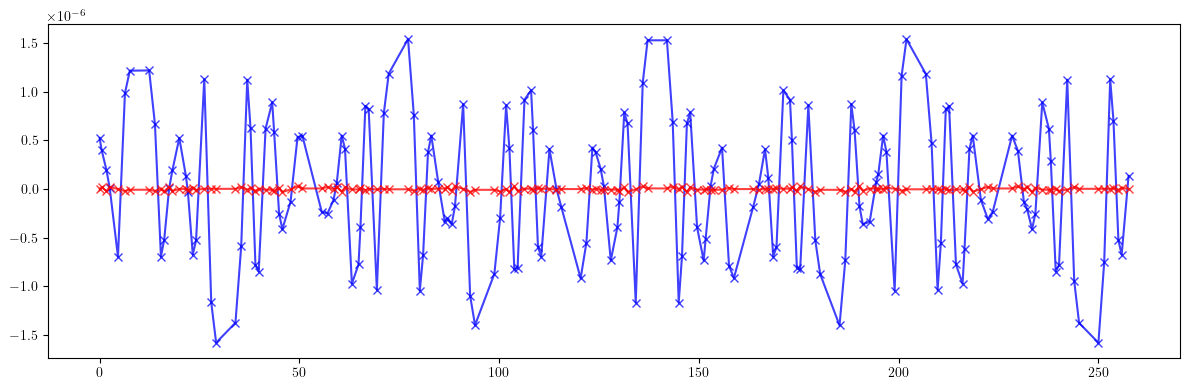

In [25]:
# Dispersion

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), (etaqx - etaqx_id).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy - etaqy_id).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

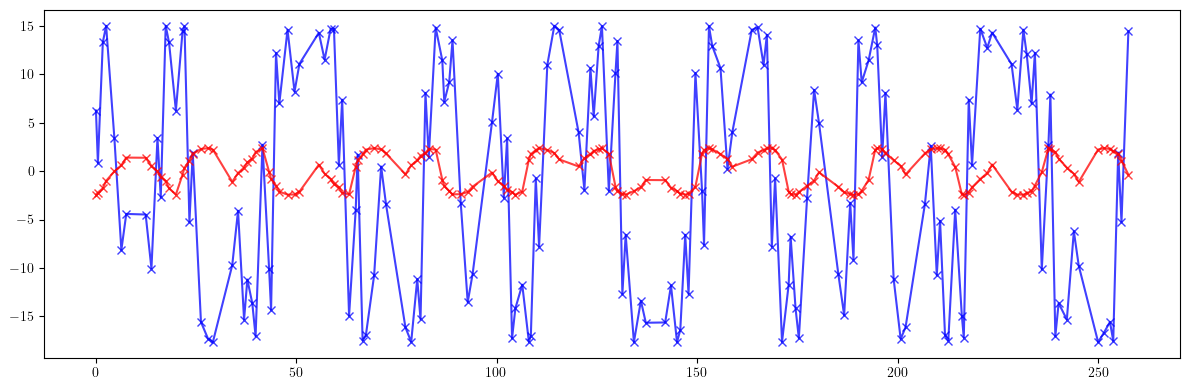

tensor(11.5994, dtype=torch.float64)
tensor(1.7916, dtype=torch.float64)


In [26]:
# Beta-beating

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_id)/bx).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_id)/by).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((bx - bx_id)/bx)**2).mean().sqrt())
print(100*(((by - by_id)/by)**2).mean().sqrt())

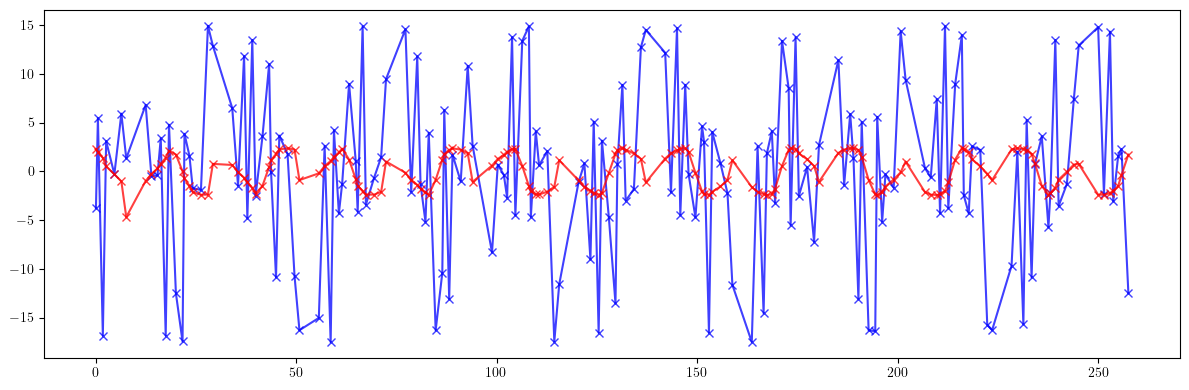

tensor(8.7941, dtype=torch.float64)
tensor(1.7778, dtype=torch.float64)


In [27]:
# Phase advance

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((mux - mux_id)/mux).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((muy - muy_id)/muy).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((mux - mux_id)/mux)**2).mean().sqrt())
print(100*(((muy - muy_id)/muy)**2).mean().sqrt())

In [28]:
# Define parametric observable vector (emulate tune measurement)

def observable_orm(nn, kn, ns, ks):
    orm = ORM(error, orbit,  [kn, ks], ('kn', None, nn, None), ('ks', None, ns, None), limit=1)
    return orm


def observable(knobs):
    (nn, kn), (ns, ks) = knobs_build(knobs)
    orm = observable_orm(nn, kn, ns, ks)
    return orm.flatten()

In [29]:
# Check the residual vector norm

knobs = torch.tensor((1 + 1 + 3 + 2)*[0.0], dtype=dtype)

print(((observable(knobs) - target)**2).sum())

tensor(1498.9104, dtype=torch.float64)


In [30]:
# Optimization loop (model free)

# Responce matrix (jacobian)

M = matrix.clone()

# Weighting covariance (sensitivity) matrix

epsilon = 1.0E-9
C = M @ M.T
C = C + epsilon*torch.eye(len(C), dtype=dtype)

# Cholesky decomposition

L = torch.linalg.cholesky(C) 

# Whiten response

M = torch.linalg.solve_triangular(L, M, upper=False)

# Additional weights
# Can be used to extra weight selected observables, e.g. tunes

weights = torch.ones(len(M), dtype=dtype)
weights = weights.sqrt()

# Whiten response with additional weights

M = M*weights.unsqueeze(1)

# Iterative correction

lr = 0.75

# Initial value

knobs = torch.tensor((1 + 1 + 3 + 2)*[0.0], dtype=dtype)

# Correction loop

for _ in range(16):
    value = observable(knobs)
    residual = target - value
    residual = torch.linalg.solve_triangular(L, residual.unsqueeze(-1), upper=False).squeeze(-1)
    residual = residual*weights
    delta = torch.linalg.lstsq(M, residual, driver="gels").solution
    knobs += lr*delta
    print(((value - target)**2).sum())
print()

tensor(1498.9104, dtype=torch.float64)
tensor(141.6352, dtype=torch.float64)
tensor(63.1585, dtype=torch.float64)
tensor(41.6462, dtype=torch.float64)
tensor(34.4239, dtype=torch.float64)
tensor(32.0550, dtype=torch.float64)
tensor(31.2752, dtype=torch.float64)
tensor(31.0157, dtype=torch.float64)
tensor(30.9293, dtype=torch.float64)
tensor(30.9007, dtype=torch.float64)
tensor(30.8913, dtype=torch.float64)
tensor(30.8882, dtype=torch.float64)
tensor(30.8872, dtype=torch.float64)
tensor(30.8869, dtype=torch.float64)
tensor(30.8868, dtype=torch.float64)
tensor(30.8868, dtype=torch.float64)



In [31]:
# Apply final corrections

(nn, kn), (ns, ks) = knobs_build(knobs)

result = error.clone()

result.flatten()

for name, knob in zip(nn, kn):
    result[name].kn = (result[name].kn + knob).item()
    
for name, knob in zip(ns, ks):
    result[name].ks = (result[name].ks + knob).item()
    
result.splice()

In [32]:
# Compute tunes (fractional part)

nux_result, nuy_result = tune(result, [], matched=True, limit=1)

In [33]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx_result, etapx_result, etaqy_result, etapy_result = dispersion(result, orbit, [], limit=1)

In [34]:
# Compute twiss parameters

ax_result, bx_result, ay_result, by_result = twiss(result, [], matched=True, advance=True, full=False).T

In [35]:
# Compute phase advances

mux_result, muy_result = advance(result, [], alignment=False, matched=True).T

In [36]:
# Compute coupling

c_result = coupling(result, [])

In [37]:
# Tune shifts

print((nux - nux_id).abs())
print((nuy - nuy_id).abs())
print()

print((nux - nux_result).abs())
print((nuy - nuy_result).abs())
print()

tensor(0.0260, dtype=torch.float64)
tensor(0.0114, dtype=torch.float64)

tensor(0.0037, dtype=torch.float64)
tensor(0.0017, dtype=torch.float64)



In [38]:
# Coupling (minimal tune distance)

print(c)
print(c_id)
print(c_result)

tensor(0., dtype=torch.float64)
tensor(0.0004, dtype=torch.float64)
tensor(7.7678e-06, dtype=torch.float64)


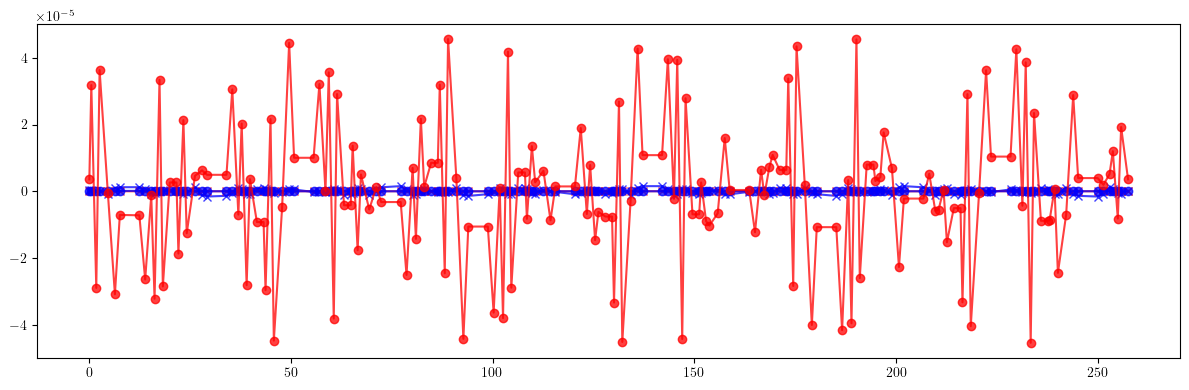

In [39]:
# Dispersion

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), (etaqx - etaqx_id).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy - etaqy_id).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqx - etaqx_result).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy - etaqy_result).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)

plt.tight_layout()
plt.show()

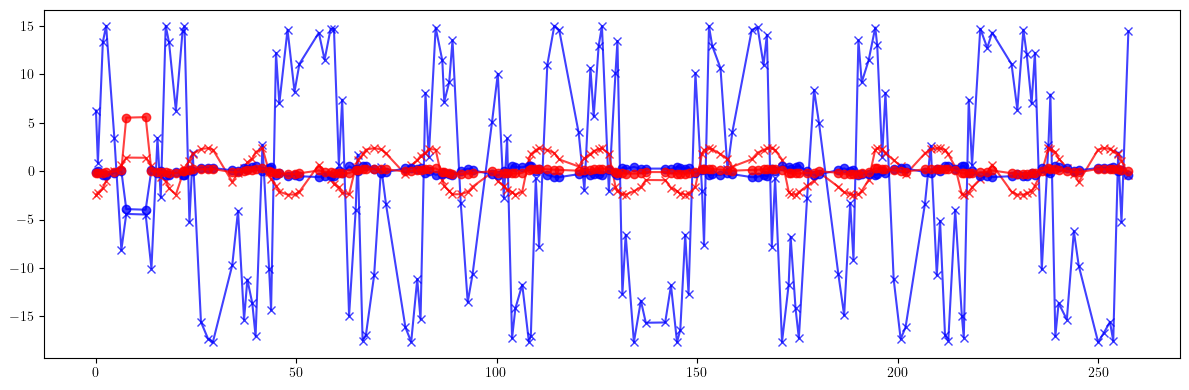

tensor(11.5994, dtype=torch.float64)
tensor(1.7916, dtype=torch.float64)

tensor(0.5500, dtype=torch.float64)
tensor(0.6339, dtype=torch.float64)



In [40]:
# Beta-beating

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_id)/bx).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_id)/by).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_result)/bx).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_result)/by).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((bx - bx_id)/bx)**2).mean().sqrt())
print(100*(((by - by_id)/by)**2).mean().sqrt())
print()

print(100*(((bx - bx_result)/bx)**2).mean().sqrt())
print(100*(((by - by_result)/by)**2).mean().sqrt())
print()

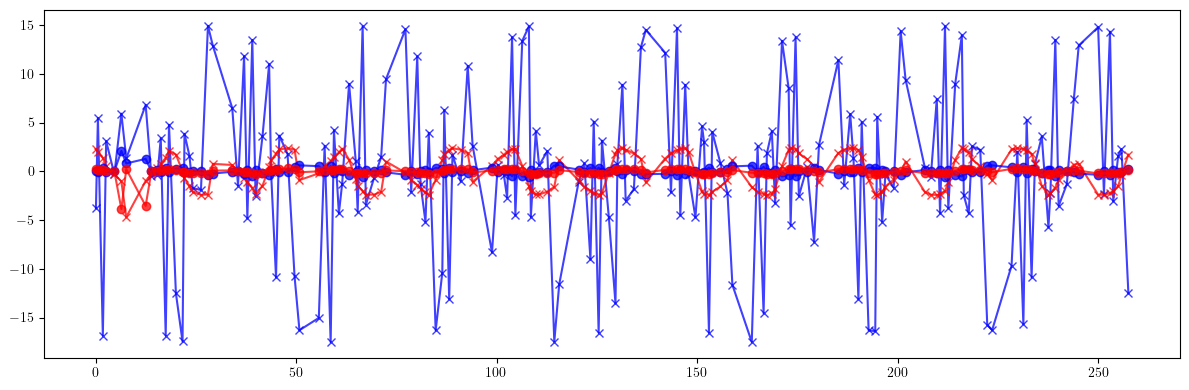

tensor(8.7941, dtype=torch.float64)
tensor(1.7778, dtype=torch.float64)

tensor(0.3300, dtype=torch.float64)
tensor(0.4437, dtype=torch.float64)



In [41]:
# Phase advance

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((mux - mux_id)/mux).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((muy - muy_id)/muy).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((mux - mux_result)/mux).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((muy - muy_result)/muy).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((mux - mux_id)/mux)**2).mean().sqrt())
print(100*(((muy - muy_id)/muy)**2).mean().sqrt())
print()

print(100*(((mux - mux_result)/mux)**2).mean().sqrt())
print(100*(((muy - muy_result)/muy)**2).mean().sqrt())
print()

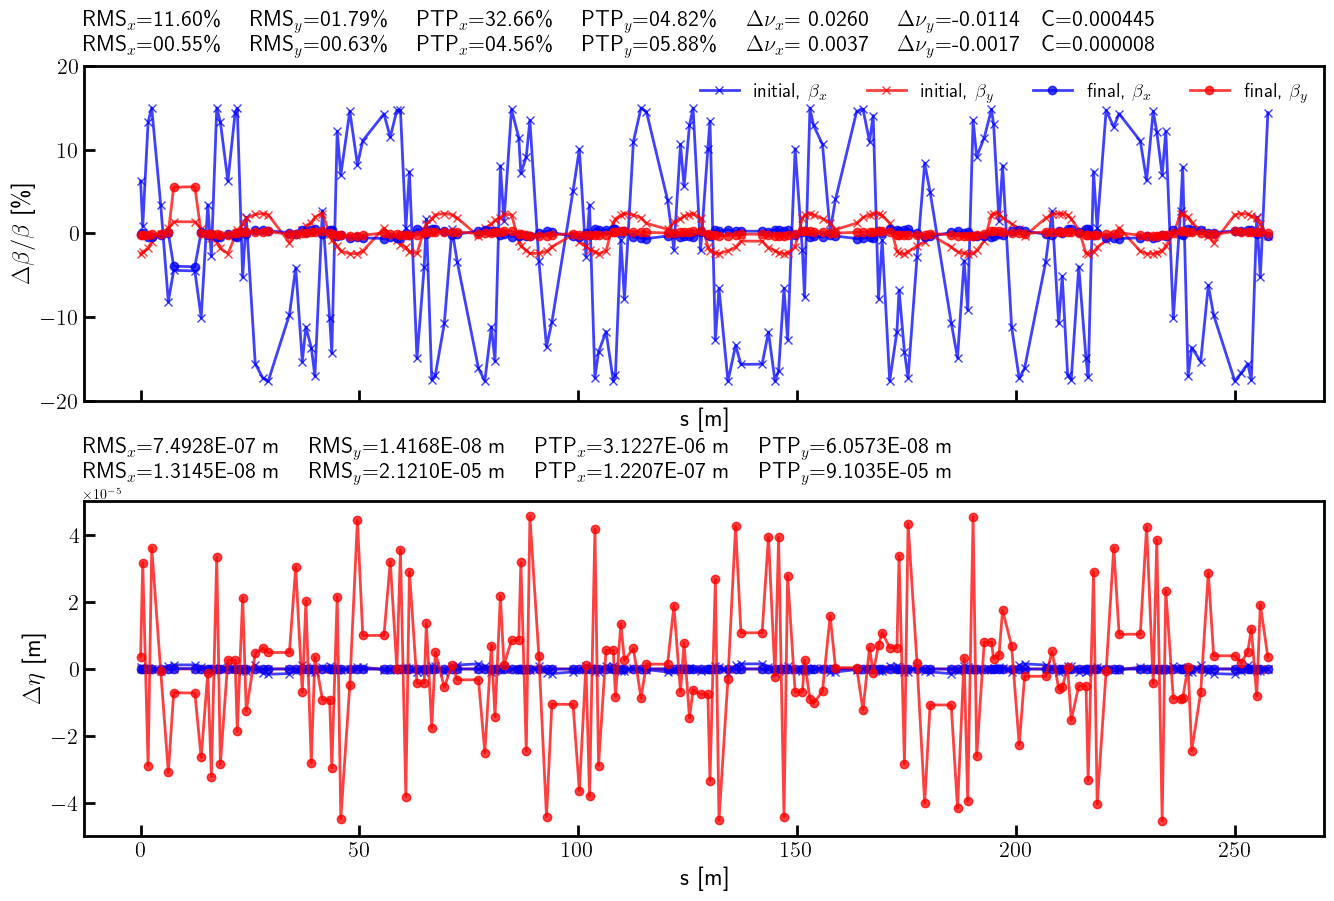

In [42]:
# Beta-beating and dispersion

bx_ref_bb = 100.0*(bx - bx_id)    / bx
by_ref_bb = 100.0*(by - by_id)    / by
bx_res_bb = 100.0*(bx - bx_result)/ bx
by_res_bb = 100.0*(by - by_result)/ by

def rms(x):
    return (x**2).mean().sqrt()

rms_x_ref = rms(bx_ref_bb).item()
ptp_x_ref = (bx_ref_bb.max() - bx_ref_bb.min()).item()
rms_y_ref = rms(by_ref_bb).item()
ptp_y_ref = (by_ref_bb.max() - by_ref_bb.min()).item()

rms_x_res = rms(bx_res_bb).item()
ptp_x_res = (bx_res_bb.max() - bx_res_bb.min()).item()
rms_y_res = rms(by_res_bb).item()
ptp_y_res = (by_res_bb.max() - by_res_bb.min()).item()

s = ring.locations().cpu().numpy()
bx_ref_np = bx_ref_bb.cpu().numpy()
by_ref_np = by_ref_bb.cpu().numpy()
bx_res_np = bx_res_bb.cpu().numpy()
by_res_np = by_res_bb.cpu().numpy()

etax_ref = etaqx - etaqx_id
etay_ref = etaqy - etaqy_id
etax_res = etaqx - etaqx_result
etay_res = etaqy - etaqy_result

rms_etax_ref = rms(etax_ref).item()
ptp_etax_ref = (etax_ref.max() - etax_ref.min()).item()
rms_etay_ref = rms(etay_ref).item()
ptp_etay_ref = (etay_ref.max() - etay_ref.min()).item()

rms_etax_res = rms(etax_res).item()
ptp_etax_res = (etax_res.max() - etax_res.min()).item()
rms_etay_res = rms(etay_res).item()
ptp_etay_res = (etay_res.max() - etay_res.min()).item()

etax_ref_np = etax_ref.cpu().numpy()
etay_ref_np = etay_ref.cpu().numpy()
etax_res_np = etax_res.cpu().numpy()
etay_res_np = etay_res.cpu().numpy()

fig, (ax, ay) = plt.subplots(
    2, 1, figsize=(16, 10),
    sharex=True,
    gridspec_kw={'hspace': 0.3}
)

ax.errorbar(s, bx_ref_np, fmt='-', marker='x', color='blue', alpha=0.75, lw=2.0, label=r'initial, $\beta_x$')
ax.errorbar(s, by_ref_np, fmt='-', marker='x', color='red',  alpha=0.75, lw=2.0, label=r'initial, $\beta_y$')
ax.errorbar(s, bx_res_np, fmt='-', marker='o', color='blue', alpha=0.75, lw=2.0, label=r'final, $\beta_x$')
ax.errorbar(s, by_res_np, fmt='-', marker='o', color='red',  alpha=0.75, lw=2.0, label=r'final, $\beta_y$')
ax.set_xlabel('s [m]', fontsize=18)
ax.set_ylabel(r'$\Delta \beta / \beta$ [\%]', fontsize=18)
ax.tick_params(width=2, labelsize=16)
ax.tick_params(axis='x', length=8, direction='in')
ax.tick_params(axis='y', length=8, direction='in')
title = (
    rf'RMS$_x$={rms_x_ref:05.2f}\% \quad RMS$_y$={rms_y_ref:05.2f}\% \quad '
    rf'PTP$_x$={ptp_x_ref:05.2f}\% \quad PTP$_y$={ptp_y_ref:05.2f}\% \quad '
    rf'$\Delta \nu_x$={(lambda x: '-' if x < 0 else '~')(nux - nux_id)}{(nux - nux_id).abs().item():.4f} \quad $\Delta \nu_y$={(lambda x: '-' if x < 0 else '~')(nuy - nuy_id)}{(nuy - nuy_id).abs().item():.4f}'
    rf'\quad C={c_id.item():.6f}'
)
ax.text(0.0, 1.10, title, transform=ax.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
title = (
    rf'RMS$_x$={rms_x_res:05.2f}\% \quad RMS$_y$={rms_y_res:05.2f}\% \quad '
    rf'PTP$_x$={ptp_x_res:05.2f}\% \quad PTP$_y$={ptp_y_res:05.2f}\% \quad '
    rf'$\Delta \nu_x$={(lambda x: '-' if x < 0 else '~')(nux - nux_result)}{(nux - nux_result).abs().item():.4f} \quad $\Delta \nu_y$={(lambda x: '-' if x < 0 else '~')(nuy - nuy_result)}{(nuy - nuy_result).abs().item():.4f}'
    rf'\quad C={c_result.item():.6f}'
)
ax.text(0.0, 1.025, title, transform=ax.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
ax.legend(loc='upper right', frameon=False, fontsize=14, ncol=4)
ax.set_ylim(-20, 20)

ay.errorbar(s, etax_ref_np, fmt='-', marker='x', color='blue', alpha=0.75, lw=2.0, label=r'initial, $\eta_x$')
ay.errorbar(s, etay_ref_np, fmt='-', marker='x', color='red', alpha=0.75, lw=2.0, label=r'initial, $\eta_y$')
ay.errorbar(s, etax_res_np, fmt='-', marker='o', color='blue',alpha=0.75, lw=2.0, label=r'final, $\eta_x$')
ay.errorbar(s, etay_res_np, fmt='-', marker='o', color='red', alpha=0.75, lw=2.0, label=r'final, $\eta_y$')
ay.set_xlabel('s [m]', fontsize=18)
ay.set_ylabel(r'$\Delta \eta$ [m]', fontsize=18)
ay.tick_params(width=2, labelsize=16)
ay.tick_params(axis='x', length=8, direction='in')
ay.tick_params(axis='y', length=8, direction='in')
title = (
    rf'RMS$_x$={rms_etax_ref:.4E} m \quad RMS$_y$={rms_etay_ref:.4E} m  \quad '
    rf'PTP$_x$={ptp_etax_ref:.4E} m \quad PTP$_y$={ptp_etay_ref:.4E} m  \quad '
)
ay.text(0.0, 1.125, title, transform=ay.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
title = (
    rf'RMS$_x$={rms_etax_res:.4E} m  \quad RMS$_y$={rms_etay_res:.4E} m  \quad '
    rf'PTP$_x$={ptp_etax_res:.4E} m  \quad PTP$_y$={ptp_etay_res:.4E} m  \quad '
)
ay.text(0.0, 1.05, title, transform=ay.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')

plt.setp(ax.spines.values(), linewidth=2.0)
plt.setp(ay.spines.values(), linewidth=2.0)

plt.show()

In [43]:
# Knobs

QF = [f'QF_S{i:02}_{j:02}' for j in [2, 3] for i in range(1, 12 + 1)]
QD = [f'QD_S{i:02}_{j:02}' for j in [2, 3] for i in range(1, 12 + 1)]

nkn = ['OCT_S01_02', 'QF_S01_02', 'QD_S01_02', 'QD_S01_03', 'QF_S01_03', 'OCT_S01_03']
nks = ['SD_S01_05', 'SH_S01_02', 'SH_S01_03', 'SD_S01_06']

ring.flatten()

kni = {name: ring[name].kn.item() for name in nkn}
ksi = {name: ring[name].ks.item() for name in nks}
kfi = {name: ring[name].kn.item() for name in QF}
kdi = {name: ring[name].kn.item() for name in QD}

result.flatten()

knf = {name: result[name].kn.item() for name in nkn}
ksf = {name: result[name].ks.item() for name in nks}
kff = {name: result[name].kn.item() for name in QF}
kdf = {name: result[name].kn.item() for name in QD}

print(dkf := [(kff[name] - kfi[name]) for name in kfi if name not in nkn])
print()

print(dkd := [(kdf[name] - kdi[name]) for name in kdi if name not in nkn])
print()

dkf, *_ = dkf
dkd, *_ = dkd

dk = {'DKF': dkf, 'DKD': dkd}

[-0.0023880025103997227, -0.0023880025103997227, -0.0023880025103997227, -0.0023880025103997227, -0.0023880025103997227, -0.0023880025103997227, -0.0023880025103997227, -0.0023880025103997227, -0.0023880025103997227, -0.0023880025103997227, -0.0023880025103997227, -0.0023880025103997227, -0.0023880025103997227, -0.0023880025103997227, -0.0023880025103997227, -0.0023880025103997227, -0.0023880025103997227, -0.0023880025103997227, -0.0023880025103997227, -0.0023880025103997227, -0.0023880025103997227, -0.0023880025103997227]

[0.005190628788120044, 0.005190628788120044, 0.005190628788120044, 0.005190628788120044, 0.005190628788120044, 0.005190628788120044, 0.005190628788120044, 0.005190628788120044, 0.005190628788120044, 0.005190628788120044, 0.005190628788120044, 0.005190628788120044, 0.005190628788120044, 0.005190628788120044, 0.005190628788120044, 0.005190628788120044, 0.005190628788120044, 0.005190628788120044, 0.005190628788120044, 0.005190628788120044, 0.005190628788120044, 0.00519

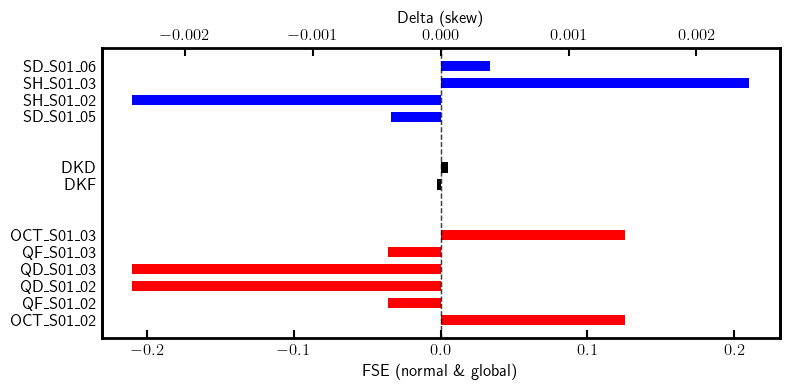

In [44]:
import numpy as np

dkn = np.array([knf[i]/kni[i] - 1 for i in kni])
dks = np.array([ksf[i] - ksi[i] for i in ksi])

n_kn = len(dkn)
n_ks = len(dks)
n_dk = len(dk)

y_kn = np.arange(n_kn)
y_dk = np.arange(n_dk) + n_kn + 2*1
y_ks = np.arange(n_ks) + n_kn + n_dk + 2*2

fig, ax = plt.subplots(figsize=(8, 4))
ay = ax.twiny()

bar_kn = ax.barh(y_kn, dkn, height=0.6, alpha=1, label=r'normal', color='red')
bar_dk = ax.barh(y_dk, list(dk.values()), height=0.6, alpha=1, label=r'global', color='black')
bar_ks = ay.barh(y_ks, dks, height=0.6, alpha=1, label=r'skew', color='blue')

yticks = np.concatenate([y_kn, y_dk, y_ks])
yticklabels = [*kni.keys()] + [*dk.keys()] + [*ksi.keys()]
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels, fontsize=12)
ay.set_ylim(ax.get_ylim())
ax.axvline(0.0, color='black', linewidth=1.0, linestyle='--', alpha=0.5)
ay.axvline(0.0, color='black', linewidth=1.0, linestyle='--', alpha=0.5)
xmax = max(np.max(np.abs(dkn)), np.max(np.abs(list(dk.values()))))
ax.set_xlim(-1.1 * xmax, 1.1 * xmax)
xmax = np.max(np.abs(dks))
ay.set_xlim(-1.1 * xmax, 1.1 * xmax)

ax.tick_params(axis='x', length=6, width=1.5, direction='in', labelsize=12, bottom=True, top=False, labelbottom=True, labeltop=False)
ax.tick_params(axis='y', length=0, width=0, labelsize=12)
ay.tick_params(axis='x', length=6, width=1.5, direction='in', labelsize=12, bottom=False, top=True, labelbottom=False, labeltop=True)

ax.set_xlabel(r'FSE (normal \& global)', fontsize=12)
ay.set_xlabel(r'Delta (skew)', fontsize=12)

plt.setp(ax.spines.values(), linewidth=2.0)
plt.setp(ay.spines.values(), linewidth=2.0)
ax.spines['top'].set_visible(False)
ay.spines['bottom'].set_visible(False)

plt.tight_layout()
plt.show()